__Initial Assymetry Detector__ 

Utilised individual component axis based reflection (asymmetry analysis) and averaged the scores across components while introducing a bias score with the more components adding to arbritray deemed irregularity. Example Usage is down the bottom of the first code cell. Afterwards their is another code cell for a data loader where file paths are needed to be updated on your machine to run

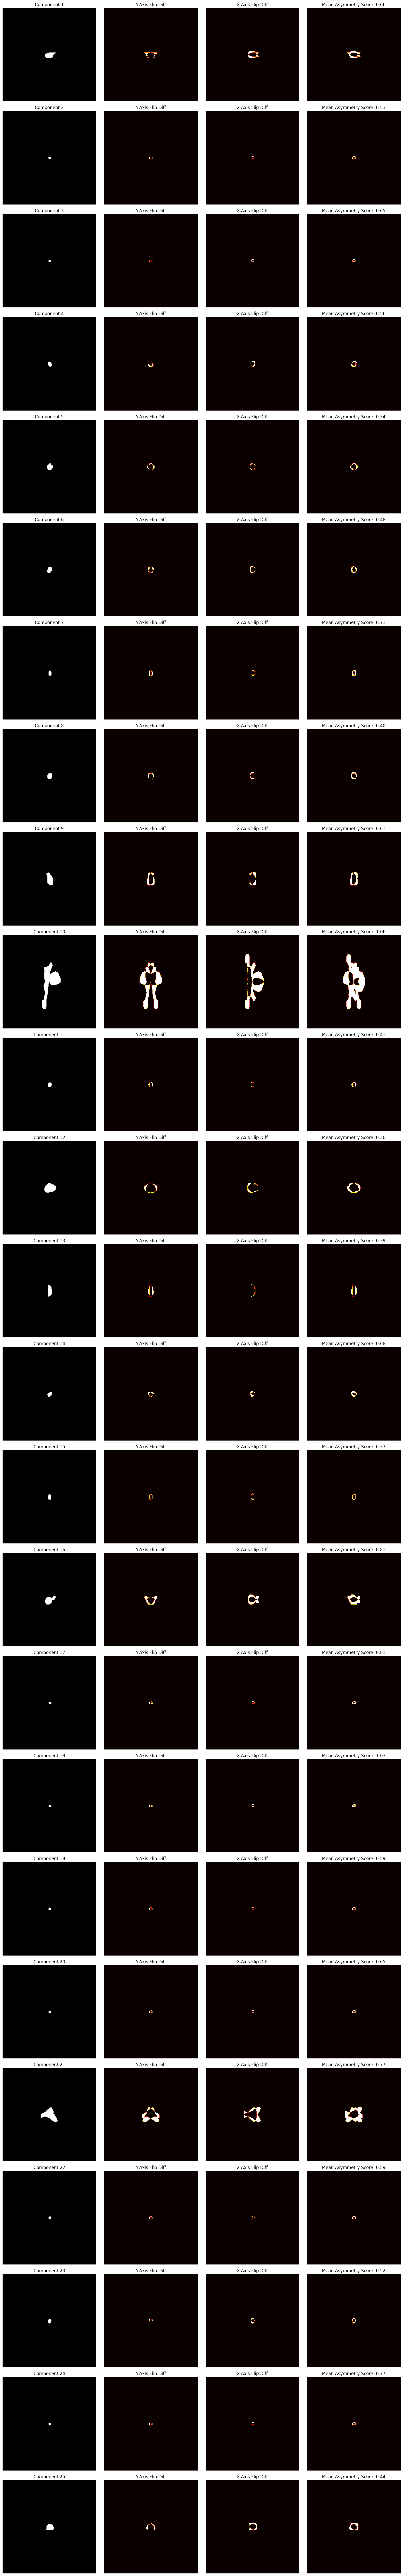

Overall Mean Asymmetry Score: 0.6056


In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

class AsymmetryDetector:
    def __init__(self, image_path):
        self.image_path = image_path
        self.binary_mask = self._load_binary_mask()
        self.binary_mask = self._crop_borders(self.binary_mask, border_px=10)
        self.components = self._get_all_components(self.binary_mask)

    def _crop_borders(self, image, border_px=10):
        """Crop a fixed number of pixels from each border."""
        h, w = image.shape
        return image[border_px:h-border_px, border_px:w-border_px]

    def _load_binary_mask(self):
        img = cv2.imread(self.image_path, cv2.IMREAD_GRAYSCALE)
        _, binary = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)
        return binary

    def _get_all_components(self, binary_image):
        num_labels, labels = cv2.connectedComponents(binary_image)
        components = []
        for label in range(1, num_labels):  # skip background
            component = (labels == label).astype(np.uint8) * 255
            component = self._center_crop(component)
            component = self._recenter_component(component)
            components.append(component)
        return components

    def _center_crop(self, image):
        h, w = image.shape
        if h % 2 != 0:
            image = image[:-1, :]
        if w % 2 != 0:
            image = image[:, :-1]
        return image

    def _recenter_component(self, image):
        M = cv2.moments(image)
        if M["m00"] == 0:
            return image
        cx = int(M["m10"] / M["m00"])
        cy = int(M["m01"] / M["m00"])
        h, w = image.shape
        center_x, center_y = w // 2, h // 2
        shift_x = center_x - cx
        shift_y = center_y - cy
        translation_matrix = np.float32([[1, 0, shift_x], [0, 1, shift_y]])
        return cv2.warpAffine(image, translation_matrix, (w, h), flags=cv2.INTER_NEAREST)

    def compute_asymmetry_scores(self):
        scores = []
        component_diffs = []

        for comp in self.components:
            flip_y = cv2.flip(comp, 1)
            flip_x = cv2.flip(comp, 0)
            diff_y = cv2.absdiff(comp, flip_y)
            diff_x = cv2.absdiff(comp, flip_x)

            total_area = np.sum(comp) + 1e-5
            score_y = np.sum(diff_y) / total_area
            score_x = np.sum(diff_x) / total_area
            mean_score = (score_y + score_x) / 2

            scores.append(mean_score)
            component_diffs.append((comp, diff_y, diff_x, mean_score))

        return scores, component_diffs

    def visualize_asymmetry(self):
        scores, component_diffs = self.compute_asymmetry_scores()
        n = len(component_diffs)
        fig, axs = plt.subplots(n, 4, figsize=(16, 4 * n))

        if n == 1:
            axs = [axs]  # Ensure it's iterable when only 1 component

        for i, (comp, diff_y, diff_x, score) in enumerate(component_diffs):
            axs[i][0].imshow(comp, cmap='gray')
            axs[i][0].set_title(f"Component {i+1}")
            axs[i][1].imshow(diff_y, cmap='hot')
            axs[i][1].set_title("Y-Axis Flip Diff")
            axs[i][2].imshow(diff_x, cmap='hot')
            axs[i][2].set_title("X-Axis Flip Diff")
            axs[i][3].imshow((diff_y + diff_x) // 2, cmap='hot')
            axs[i][3].set_title(f"Mean Asymmetry Score: {score:.2f}")

            for ax in axs[i]:
                ax.axis('off')

        plt.tight_layout()
        plt.show()

        mean_score = np.mean(scores)
        print(f"Overall Mean Asymmetry Score: {mean_score:.4f}")
        return mean_score


# Example usage
if __name__ == "__main__":
    image_path = r"C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\lesion_masks\PAT_87_133_810_mask.png"
    detector = AsymmetryDetector(image_path)
    overall_score = detector.visualize_asymmetry()


__Data Loader__

Outputs a csv of asymmetry and bias score

In [15]:
import os
import pandas as pd
import numpy as np


# --- Paths ---
csv_path = r"C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\metadata_clean_valid_mask_only.csv"
image_dir = r"C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\padchest_lesion_masks\lesion_masks"
output_csv = r"C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\multiLesion_mean_scores.csv"

# --- Load CSV ---
df = pd.read_csv(csv_path)

# --- Helper: Clean image id and form file path ---
def get_mask_path(img_id, folder):
    base = os.path.splitext(img_id)[0]
    return os.path.join(folder, f"{base}_mask.png")

# --- Process Images ---
results = []

for img_id in df['img_id']:
    mask_path = get_mask_path(img_id, image_dir)
    if os.path.exists(mask_path):
        try:
            detector = AsymmetryDetector(mask_path)
            scores, _ = detector.compute_asymmetry_scores()
            mean_score = float(np.mean(scores)) if scores else np.nan
            component_count = len(scores)

            # Bias increases with number of components
            biased_score = mean_score * np.log1p(component_count) if component_count > 0 else np.nan

            results.append({
                "img_id": img_id,
                "mean_asymmetry": mean_score,
                # "component_count": component_count,
                "biased_asymmetry": biased_score
            })

        except Exception as e:
            print(f"❌ Error processing {img_id}: {e}")
    else:
        print(f"⚠️ Missing file: {mask_path}")

# --- Save to CSV ---
if results:
    result_df = pd.DataFrame(results)
    result_df.to_csv(output_csv, index=False)
    print(f"✅ Saved asymmetry scores to: {output_csv}")
else:
    print("⚠️ No results to save. Check if any valid masks were processed.")

✅ Saved asymmetry scores to: C:\Users\Peter\Documents\Data Science\Semester 2 - Projects in Data Science\FinalData\multiLesion_mean_scores.csv
